## Helper Functions

In [24]:
def compare_mse(sess, y_, train_x, test_x, kp):
    if (kp < 1):
        pred_y = sess.run(y_, feed_dict = {X:test_x, keep_prob:kp})
        mse = tf.reduce_mean(tf.square(pred_y - test_y))
        print("MSE Test: %.4f" % sess.run(mse))

        pred_y = sess.run(y_, feed_dict = {X:train_x, keep_prob:kp})
        mse = tf.reduce_mean(tf.square(pred_y - train_y))
        print("MSE Train: %.4f" % sess.run(mse))
    else:
        pred_y = sess.run(y_, feed_dict = {X:test_x})
        mse = tf.reduce_mean(tf.square(pred_y - test_y))
        print("MSE Test: %.4f" % sess.run(mse))

        pred_y = sess.run(y_, feed_dict = {X:train_x})
        mse = tf.reduce_mean(tf.square(pred_y - train_y))
        print("MSE Train: %.4f" % sess.run(mse))

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import numpy as np

from sklearn.datasets import load_boston

Let's load the boston data set

In [26]:
boston = load_boston()
features = np.array(boston.data)
labels = np.array(boston.target)

In [27]:
print(boston["DESCR"])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

## Prepare the data set

Let's write a helper function to normalize the dataset

In [28]:
def normalize(dataset):
    mu = np.mean(dataset, axis = 0)
    sigma = np.std(dataset, axis = 0)
    return (dataset-mu)/sigma

Let's get the dimension of the data set now

In [29]:
n_training_samples = features.shape[0]
n_dim = features.shape[1]

print(n_training_samples)
print(n_dim)

506
13


Let's append the bias to the data...

In [30]:
def append_bias(features, labels):
    f = np.reshape(np.c_[np.ones(n_training_samples), features], [n_training_samples, n_dim+1])
    l = np.reshape(labels, [n_training_samples,1])
    return f,l

In [31]:
features_norm = normalize(features)
f, l = append_bias(features_norm, labels)

Let's build a train and a test sets splitting them randomly 80/20

In [32]:
rnd = np.random.rand(len(f)) < 0.8

train_x = f[rnd]
train_y = l[rnd]
test_x = f[~rnd]
test_y = l[~rnd]

# Linear Regression

## Let's start with tensorflow modelling for a linear regression

In [33]:
learning_rate = 0.01
training_epochs = 10000
cost_history = np.empty(shape=[1], dtype = float)

Now let's define the variables and place holders

In [34]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_dim+1])
Y = tf.placeholder(tf.float32, [None,1])
W = tf.Variable(tf.ones([n_dim+1,1]))

init = tf.global_variables_initializer()

In [35]:
y_ = tf.matmul(X,W)
cost = tf.reduce_mean(tf.square(y_-Y))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [36]:
sess = tf.Session()
sess.run(init)

cost_history = []
for epoch in range(training_epochs+1):
    sess.run(training_step, feed_dict = {X: train_x, Y: train_y})
    cost_ = sess.run(cost, feed_dict={ X:train_x, Y: train_y})
    cost_history = np.append(cost_history, cost_)
    
    if (epoch % 1000 == 0):
        print("Reached epoch",epoch,"cost J =", cost_)

Reached epoch 0 cost J = 550.087
Reached epoch 1000 cost J = 20.9227
Reached epoch 2000 cost J = 20.8655
Reached epoch 3000 cost J = 20.8598
Reached epoch 4000 cost J = 20.8592
Reached epoch 5000 cost J = 20.8591
Reached epoch 6000 cost J = 20.8591
Reached epoch 7000 cost J = 20.8591
Reached epoch 8000 cost J = 20.8591
Reached epoch 9000 cost J = 20.8591
Reached epoch 10000 cost J = 20.8591


We can then print the values we have found for $W$

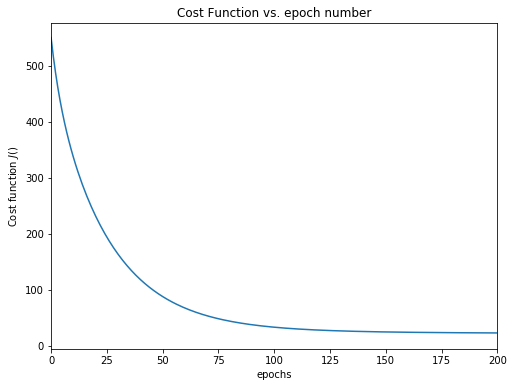

In [40]:
plt.figure(figsize=(8,6))
plt.title("Cost Function vs. epoch number")
plt.xlabel("epochs")
plt.ylabel("Cost function $J()$")
plt.xlim(0,200)
plt.plot(range(len(cost_history)), cost_history)

Let's check the results

MSE: 26.6125


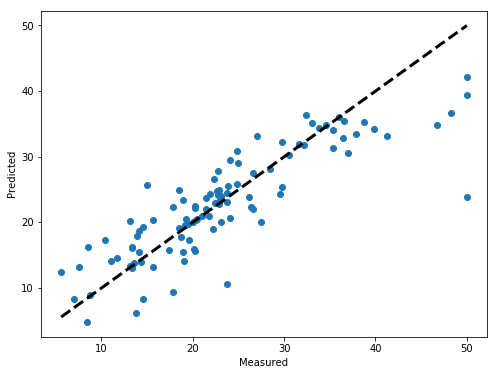

In [41]:
pred_y = sess.run(y_, feed_dict = {X:test_x})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw = 3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

To check for overfitting (in case of linear regression this is a useless exercise, but I find it instructive) we need to compare the MSE for the train and test set

In [42]:
compare_mse(sess, y_, train_x, test_x, 1)

MSE Test: 26.6125
MSE Train: 20.8591


The two values are comparable.

In [43]:
sess.close()

## Let's build a NN now

## 1 layer network with ReLu activation functions

In [44]:
tf.reset_default_graph()

learning_rate = 0.1
training_epochs = 5000

# Number of neurons in the layers
n1 = 5

cost_history = np.empty(shape=[1], dtype = float)

X = tf.placeholder(tf.float32, [None, n_dim+1])
Y = tf.placeholder(tf.float32, [None,1])
W1 = tf.Variable(tf.random_normal([n_dim+1,n1], stddev=1))
W2 = tf.Variable(tf.random_normal([n1,1], stddev=1))

init = tf.global_variables_initializer()

# Let's build our network...
layer1 = tf.nn.relu(tf.matmul(X, W1))
output_layer = tf.nn.relu(tf.matmul(layer1, W2))


cost = tf.reduce_mean(tf.square(output_layer-Y))
#training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [45]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
    
cost_history = []
for epoch in range(training_epochs+1):

    sess.run(optimizer, feed_dict = {X: train_x, Y: train_y})
    cost_ = sess.run(cost, feed_dict={ X:train_x, Y: train_y})
    cost_history = np.append(cost_history, cost_)
    
    if (epoch % 1000 == 0):
        print("Reached epoch",epoch,"cost J =", cost_)

Reached epoch 0 cost J = 146.427
Reached epoch 1000 cost J = 6.54374
Reached epoch 2000 cost J = 6.28204
Reached epoch 3000 cost J = 6.29645
Reached epoch 4000 cost J = 6.28918
Reached epoch 5000 cost J = 6.13609


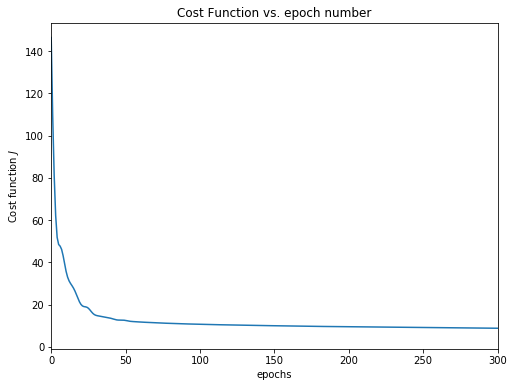

In [46]:
plt.figure(figsize=(8,6))
plt.title("Cost Function vs. epoch number")
plt.xlabel("epochs")
plt.xlim((0,300))
plt.ylabel("Cost function $J$")
plt.plot(range(len(cost_history)), cost_history)

MSE: 12.9955


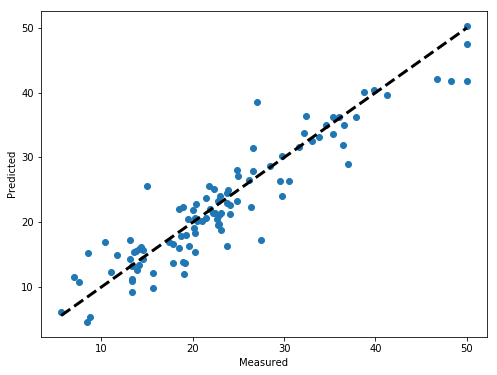

In [47]:
pred_y = sess.run(output_layer, feed_dict = {X:test_x})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw = 3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Let's check for overfitting...

In [48]:
compare_mse(sess, output_layer, train_x, test_x, 1.0)

MSE Test: 12.9955
MSE Train: 6.1361


In [49]:
sess.close()

## 2 layer network with relu

In [50]:
tf.reset_default_graph()

learning_rate = 0.001
training_epochs = 10000

# Number of neurons in the layers
n1 = 5 # Number of neurons in layer 1
n2 = 5 # Number of neurons in layer 2

cost_history = np.empty(shape=[1], dtype = float)

X = tf.placeholder(tf.float32, [None, n_dim+1])
Y = tf.placeholder(tf.float32, [None,1])
W1 = tf.Variable(tf.random_normal([n_dim+1,n1], stddev=1))
W2 = tf.Variable(tf.random_normal([n1,n2], stddev=1))
W3 = tf.Variable(tf.random_normal([n2,1], stddev=1))

init = tf.global_variables_initializer()

# Let's build our network...
layer1 = tf.nn.relu(tf.matmul(X, W1))
layer2 = tf.nn.relu(tf.matmul(layer1, W2))
output_layer = tf.nn.relu(tf.matmul(layer2, W3))


cost = tf.reduce_mean(tf.square(output_layer-Y))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
#optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [51]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
    
cost_history = []
for epoch in range(training_epochs+1):
    
    sess.run(training_step, feed_dict = {X: train_x, Y: train_y})
    cost_ = sess.run(cost, feed_dict={ X:train_x, Y: train_y})
    cost_history = np.append(cost_history, cost_)
    
    if (epoch % 1000 == 0):
        print("Reached epoch",epoch,"cost J =", cost_)

Reached epoch 0 cost J = 315.116
Reached epoch 1000 cost J = 13.5424
Reached epoch 2000 cost J = 11.0348
Reached epoch 3000 cost J = 9.99658
Reached epoch 4000 cost J = 9.45586
Reached epoch 5000 cost J = 9.1739
Reached epoch 6000 cost J = 8.93454
Reached epoch 7000 cost J = 8.61927
Reached epoch 8000 cost J = 8.23065
Reached epoch 9000 cost J = 7.89786
Reached epoch 10000 cost J = 7.69966


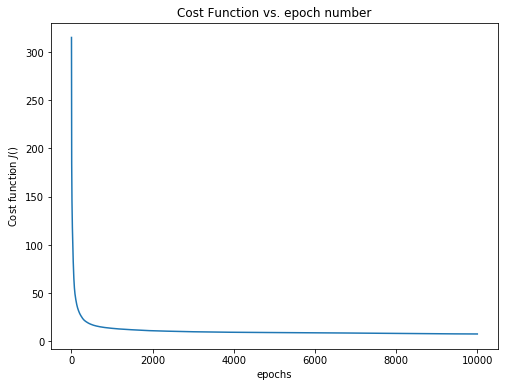

In [52]:
plt.figure(figsize=(8,6))
plt.title("Cost Function vs. epoch number")
plt.xlabel("epochs")
plt.ylabel("Cost function $J()$")
plt.plot(range(len(cost_history)), cost_history)

In [53]:
compare_mse(sess, output_layer, train_x, test_x,1)

MSE Test: 14.6859
MSE Train: 7.6997


MSE: 14.6859


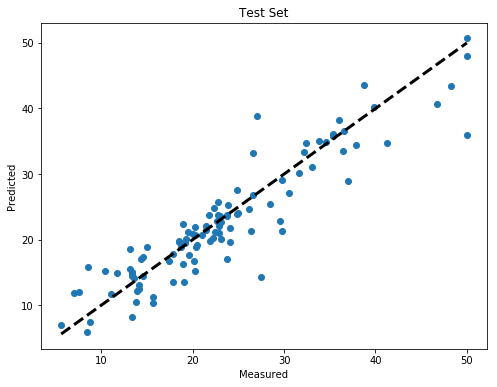

In [54]:
pred_y = sess.run(output_layer, feed_dict = {X:test_x})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw = 3)
ax.set_title('Test Set')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Let's see how good we do on the training set

MSE: 7.6997


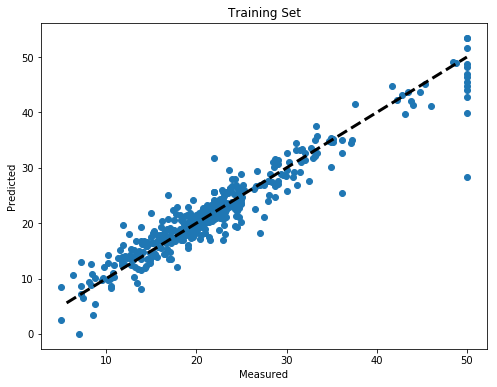

In [55]:
pred_y = sess.run(output_layer, feed_dict = {X:train_x})
mse = tf.reduce_mean(tf.square(pred_y - train_y))
print("MSE: %.4f" % sess.run(mse))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(train_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw = 3)
ax.set_title('Training Set')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

## 2 Layer network with sigmoid activation function for the hidden layers

In [56]:
tf.reset_default_graph()

learning_rate = 0.1
training_epochs = 10000
visualisation_step = 1000

# Number of neurons in the layers
n1 = 10
n2 = 10

cost_history = np.empty(shape=[1], dtype = float)

X = tf.placeholder(tf.float32, [None, n_dim+1])
Y = tf.placeholder(tf.float32, [None,1])
W1 = tf.Variable(tf.random_normal([n_dim+1,n1], stddev=1)) 
W2 = tf.Variable(tf.random_normal([n1,n2], stddev=1))
W3 = tf.Variable(tf.random_normal([n2,1], stddev=1))

init = tf.global_variables_initializer()

# Let's build our network...
layer1 = tf.nn.sigmoid(tf.matmul(X, W1))
layer2 = tf.nn.sigmoid(tf.matmul(layer1, W2))
output_layer = tf.matmul(layer2, W3) # identity


cost = tf.reduce_mean(tf.square(output_layer-Y))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [57]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
        
print ('Adam optimisation')
cost_history_adam = []
for epoch in range(training_epochs+1):
    sess.run(optimizer, feed_dict = {X: train_x, Y: train_y})
    cost_ = sess.run(cost, feed_dict={ X:train_x, Y: train_y})
    cost_history_adam = np.append(cost_history_adam, cost_)
    
    if (epoch % visualisation_step == 0):
        print("Reached epoch",epoch,"cost J =", cost_)


Adam optimisation
Reached epoch 0 cost J = 589.82
Reached epoch 1000 cost J = 1.83463
Reached epoch 2000 cost J = 1.37974
Reached epoch 3000 cost J = 1.04003
Reached epoch 4000 cost J = 0.921328
Reached epoch 5000 cost J = 0.861174
Reached epoch 6000 cost J = 0.818451
Reached epoch 7000 cost J = 0.803475
Reached epoch 8000 cost J = 0.790682
Reached epoch 9000 cost J = 0.734299
Reached epoch 10000 cost J = 0.721215


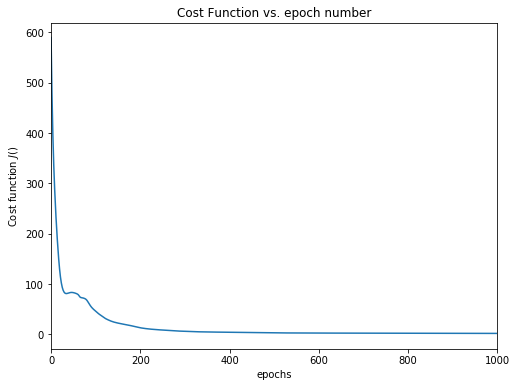

In [58]:
plt.figure(figsize=(8,6))
plt.title("Cost Function vs. epoch number")
plt.xlabel("epochs")
plt.ylabel("Cost function $J()$")
plt.xlim((0,1000))
plt.plot(range(len(cost_history_adam)), cost_history_adam)

MSE: 36.6684


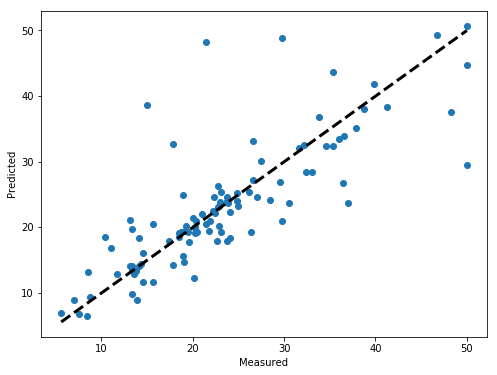

In [59]:
pred_y = sess.run(output_layer, feed_dict = {X:test_x})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw = 3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [60]:
compare_mse(sess, output_layer, train_x, test_x,1)

MSE Test: 36.6684
MSE Train: 0.7212


Not generalizing enough...

Let's see how good we do on the training set

MSE: 0.7212


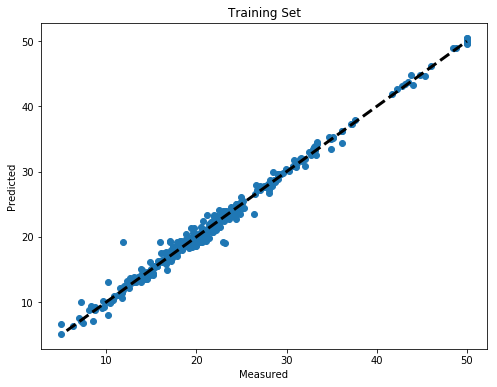

In [61]:
pred_y = sess.run(output_layer, feed_dict = {X:train_x})
mse = tf.reduce_mean(tf.square(pred_y - train_y))
print("MSE: %.4f" % sess.run(mse))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(train_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw = 3)
ax.set_title('Training Set')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

This is a CLEAR case of overfitting!

In [62]:
sess.close()

## Regularisation with dropout

Let's build a model with dropout (regularization)

In [68]:
tf.reset_default_graph()

learning_rate = 0.1
visualisation_step = 1000


# Number of neurons in the layers
n1 = 5
n2 = 5

cost_history = np.empty(shape=[1], dtype = float)

X = tf.placeholder(tf.float32, [None, n_dim+1])
Y = tf.placeholder(tf.float32, [None,1])
W1 = tf.Variable(tf.random_normal([n_dim+1,n1], stddev=1)) 
W2 = tf.Variable(tf.random_normal([n1,n2], stddev=1))
W3 = tf.Variable(tf.random_normal([n2,1], stddev=1))
keep_prob = tf.placeholder(tf.float32)

init = tf.global_variables_initializer()

# Let's build our network...
layer1 = tf.nn.sigmoid(tf.matmul(X, W1))
layer1_d = tf.nn.dropout(layer1, keep_prob)
layer2 = tf.nn.sigmoid(tf.matmul(layer1_d, W2))
layer2_d = tf.nn.dropout(layer2, keep_prob)
output_layer = tf.matmul(layer2_d, W3) # identity


cost = tf.reduce_mean(tf.square(output_layer-Y))
gd = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [73]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
     
kp = 0.75
training_epochs = 15000
    
print ('Adam optimisation')
cost_history_adam = []
for epoch in range(training_epochs+1):
    sess.run(optimizer, feed_dict = {X: train_x, Y: train_y, keep_prob : kp})
    cost_ = sess.run(cost, feed_dict={ X:train_x, Y: train_y, keep_prob : kp})
    cost_history_adam = np.append(cost_history_adam, cost_)
    
    if (epoch % visualisation_step == 0):
        print("Reached epoch",epoch,"cost J =", cost_)

Adam optimisation
Reached epoch 0 cost J = 581.412
Reached epoch 1000 cost J = 69.3117
Reached epoch 2000 cost J = 48.1366
Reached epoch 3000 cost J = 54.2707
Reached epoch 4000 cost J = 62.8927
Reached epoch 5000 cost J = 55.6094
Reached epoch 6000 cost J = 54.1528
Reached epoch 7000 cost J = 53.0888
Reached epoch 8000 cost J = 62.0848
Reached epoch 9000 cost J = 62.3421
Reached epoch 10000 cost J = 53.6195
Reached epoch 11000 cost J = 60.3346
Reached epoch 12000 cost J = 76.0448
Reached epoch 13000 cost J = 57.9785
Reached epoch 14000 cost J = 64.8142
Reached epoch 15000 cost J = 52.3097


MSE: 29.9487


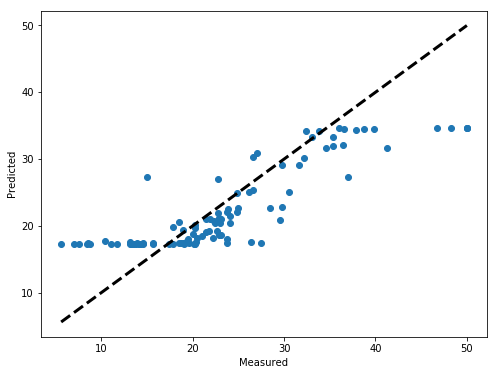

In [77]:
pred_y = sess.run(output_layer, feed_dict = {X:test_x, keep_prob:1.0})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw = 3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

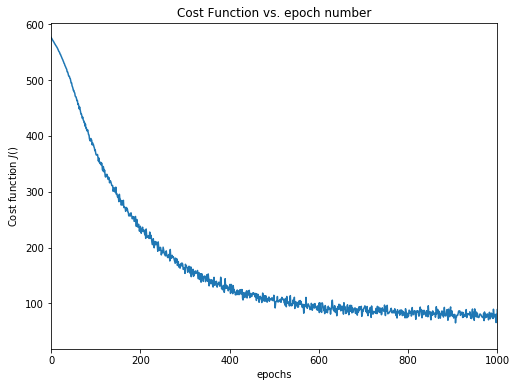

In [71]:
plt.figure(figsize=(8,6))
plt.title("Cost Function vs. epoch number")
plt.xlabel("epochs")
plt.ylabel("Cost function $J()$")
plt.xlim((0,1000))
plt.plot(range(len(cost_history_adam)), cost_history_adam)

MSE: 31.2973


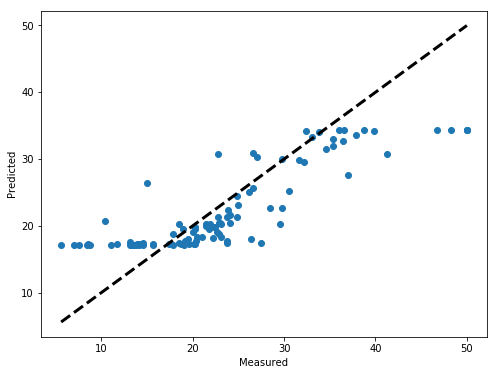

In [72]:
pred_y = sess.run(output_layer, feed_dict = {X:test_x, keep_prob:1})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw = 3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

MSE: 22.9525


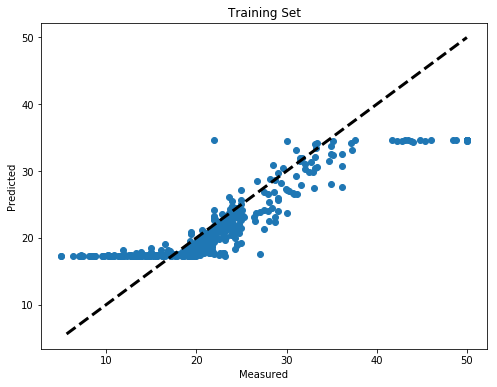

In [78]:
pred_y = sess.run(output_layer, feed_dict = {X:train_x, keep_prob : 1})
mse = tf.reduce_mean(tf.square(pred_y - train_y))
print("MSE: %.4f" % sess.run(mse))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(train_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw = 3)
ax.set_title('Training Set')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [44]:
sess.close()

# Tensorboard integration

In [85]:
tf.reset_default_graph()

learning_rate = 0.1


# Number of neurons in the layers
n1 = 10
n2 = 10

cost_history = np.empty(shape=[1], dtype = float)

X = tf.placeholder(tf.float32, [None, n_dim+1])
Y = tf.placeholder(tf.float32, [None,1])
W1 = tf.Variable(tf.random_normal([n_dim+1,n1], stddev=1)) 
W2 = tf.Variable(tf.random_normal([n1,n2], stddev=1))
W3 = tf.Variable(tf.random_normal([n2,1], stddev=1))
keep_prob = tf.placeholder(tf.float32)

#init = tf.global_variables_initializer()

# Let's build our network...
layer1 = tf.nn.sigmoid(tf.matmul(X, W1))
layer1_d = tf.nn.dropout(layer1, keep_prob)
layer2 = tf.nn.sigmoid(tf.matmul(layer1_d, W2))
layer2_d = tf.nn.dropout(layer2, keep_prob)
output_layer = tf.matmul(layer2_d, W3) # identity


cost = tf.reduce_mean(tf.square(output_layer-Y))

tf.summary.scalar("cost_function", cost)
merged_summary_op = tf.summary.merge_all()


gd = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [86]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

writer = tf.summary.FileWriter('/Users/umberto/logs/run1010', graph=tf.get_default_graph())

kp = 0.75
training_epochs = 5000
visualisation_step = 100
    
print ('Adam optimisation')
cost_history_adam = []
for epoch in range(training_epochs+1):
    _, c, summary = sess.run([optimizer, cost, merged_summary_op], feed_dict = {X: train_x, Y: train_y, keep_prob : kp})
    cost_ = sess.run(cost, feed_dict={ X:train_x, Y: train_y, keep_prob : kp})
    cost_history_adam = np.append(cost_history_adam, cost_)
    
    writer.add_summary(summary, epoch )
    
    
    if (epoch % visualisation_step == 0):
        print("Reached epoch",epoch,"cost J =", cost_)

Adam optimisation
Reached epoch 0 cost J = 650.956
Reached epoch 100 cost J = 67.8571
Reached epoch 200 cost J = 48.6174
Reached epoch 300 cost J = 43.2758
Reached epoch 400 cost J = 47.0001
Reached epoch 500 cost J = 49.4333
Reached epoch 600 cost J = 42.1152
Reached epoch 700 cost J = 43.3803
Reached epoch 800 cost J = 37.2008
Reached epoch 900 cost J = 44.5609
Reached epoch 1000 cost J = 43.3043
Reached epoch 1100 cost J = 41.9491
Reached epoch 1200 cost J = 40.0307
Reached epoch 1300 cost J = 41.8993
Reached epoch 1400 cost J = 38.7804
Reached epoch 1500 cost J = 37.2436
Reached epoch 1600 cost J = 35.8653
Reached epoch 1700 cost J = 40.5399
Reached epoch 1800 cost J = 37.4692
Reached epoch 1900 cost J = 35.5163
Reached epoch 2000 cost J = 39.4038
Reached epoch 2100 cost J = 34.7177
Reached epoch 2200 cost J = 39.5549
Reached epoch 2300 cost J = 41.2478
Reached epoch 2400 cost J = 44.9615
Reached epoch 2500 cost J = 38.2527
Reached epoch 2600 cost J = 39.03
Reached epoch 2700 cost 

MSE: 27.5025


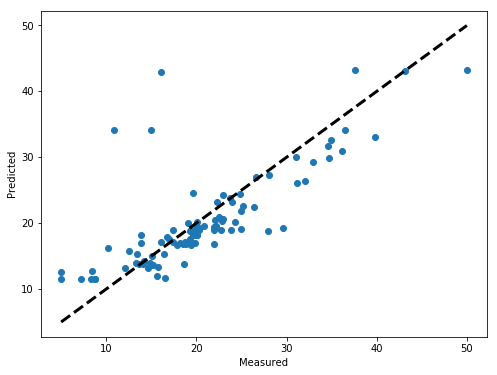

In [87]:
pred_y = sess.run(output_layer, feed_dict = {X:test_x, keep_prob:1})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw = 3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()